# Time series forecasting in TensorFlow (BitPredict 💰📈)

We're going to be building a series of models in an attempt to predict the price of Bitcoin. 

## What is a time series problem?

Time series problems deal with data over time.

Such as, the number of staff members in a company over 10-years, sales of computers for the past 5-years, electricity usage for the past 50-years.

## What we're going to cover

* Get time series data (the historical price of Bitcoin)
  * Load in time series data using pandas/Python's CSV module
* Format data for a time series problem
  * Creating training and test sets
  * Visualizing time series data
  * Turning time series data into a supervised learning problem (windowing)
  * Preparing univariate and multivariate (more than one variable) data
* Evaluating a time series forecasting model
* Setting up a series of deep learning modelling experiments
  * Dense (fully-connected) networks
  * Sequence models (LSTM and 1D CNN)
  * Ensembling (combining multiple models together)
  * Multivariate models
  * Replicating the N-BEATS algorithm using TensorFlow layer subclassing
* Creating a modelling checkpoint to save the best performing model during training
* Making predictions (forecasts) with a time series model
* Creating prediction intervals for time series model forecasts
* Discussing two different types of uncertainty in machine learning (data uncertainty and model uncertainty)


## Get data

To build a time series forecasting model, the first thing we're going to need is data.

And since we're trying to predict the price of Bitcoin, we'll need Bitcoin data.

Specifically, we're going to get the prices of Bitcoin from 01 October 2013 to 18 May 2021.


> 📖 **Resource:** To get the Bitcoin historical data, I used the data on [GitHub](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv).

In [1]:
# Download Bitcoin historical data from GitHub 
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv --no-check-certificate 

### Importing time series data with pandas
Now we've got some data to work with, let's import it using pandas so we can visualize it.

And because our data has a date component, we'll parse the dates using the `parse_dates` parameter passing it the name our of the date column ("Date").

In [2]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's only 2787 total samples.

> 🔑 **Note:** The frequency at which a time series value is collected is often referred to as **seasonality**. This is usually mesaured in number of samples per year. For example, collecting the price of Bitcoin once per day would result in a time series with a seasonality of 365. Time series data collected with different seasonality values often exhibit seasonal patterns (e.g. electricity demand behing higher in Summer months for air conditioning than Winter months). 
> 
> source: [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html).

![different types of time series patterns](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-types-of-time-series-patterns.png)
*Example of different kinds of patterns you'll see in time series data. Notice the bottom right time series (Google stock price changes) has little to no patterns, making it difficult to predict. See [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html) for full graphic.*


To simplify, let's remove some of the columns from our data so we're only left with a date index and the closing price.

In [5]:
# Only want closing price for each day 
bitcoin_prices=pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)':'Price'})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


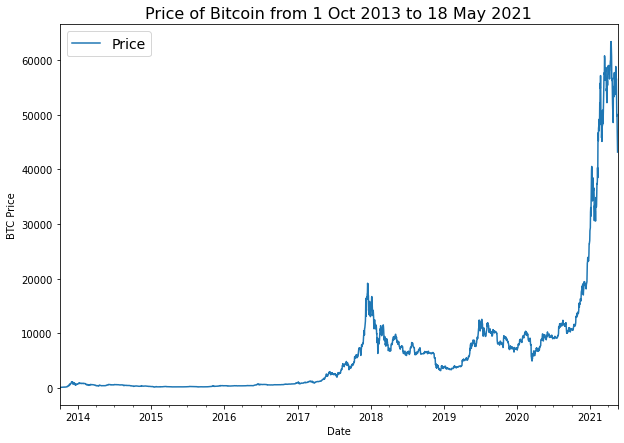

In [6]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Format Data Part 1: Creatining train and test sets for time series data

In [7]:
import numpy as np
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

### Create train & test sets for time series

To do this, we can create an abitrary point in time to split our data.

Everything before the point in time can be considered the training set and everything after the point in time can be considered the test set.

![time series train test split](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-train-test-split.png)
*Demonstration of time series split. Rather than a traditionaly random train/test split, it's best to split the time series data sequentially. Meaning, the test data should be data from the future when compared to the training data.*

In [8]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

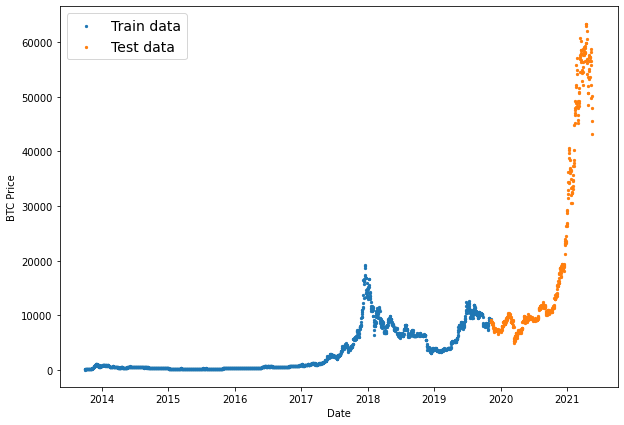

In [9]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create a plotting function

In [10]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

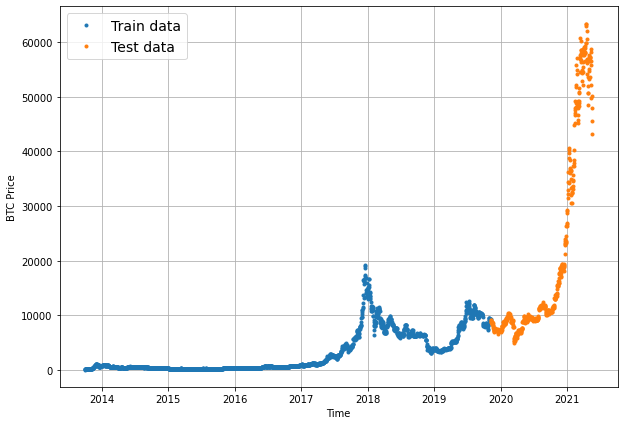

In [11]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

Before we discuss what modelling experiments we're going to run, there are two terms you should be familiar with, **horizon** and **window**. 
  * **horizon** = number of timesteps to predict into future
  * **window** = number of timesteps from past used to predict **horizon**

For example, if we wanted to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and the window would be 7.

Now, how about those modelling experiments?

| Model Number | Model Type | Horizon size | Window size | Extra data |
| ----- | ----- | ----- | ----- | ----- |
| 0 | Naïve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA | 
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (but with multivariate data) | 1 | 7 | Block reward size |
| 7 | [N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA | 
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA| 

## Model 0: Naïve forecast (baseline)

One of the most common baseline models for time series forecasting, the naïve model (also called the [naïve forecast](https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method)).
The naïve model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$ 

> The prediction at timestep `t` (y-hat) is equal to the value at timestep `t-1` (the previous timestep).

In an open system (like a stock market or crypto market), we'll often find beating the naïve forecast with *any* kind of model is quite hard.

> 🔑 **Note:** 
> - **open system** is a system where inputs and outputs can freely flow, such as a market (stock or crypto).
> - **closed system** the inputs and outputs are contained within the system (like a poker game with your buddies, you know the buy in and you know how much the winner can get).
> - Time series forecasting in **open systems** is generally quite poor.

In [12]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value

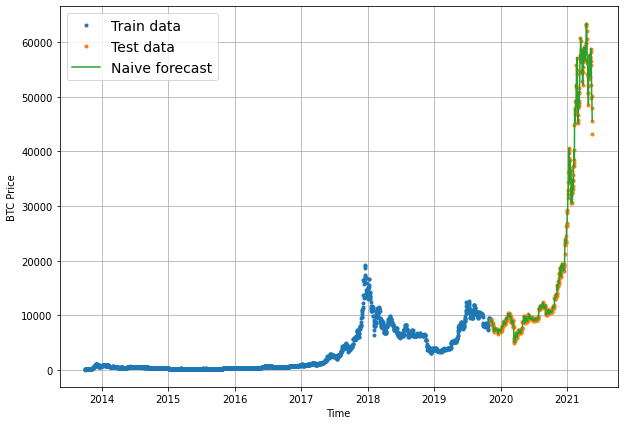

In [13]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

The naive forecast looks like it's following the data well. 

Let's zoom in to take a better look.

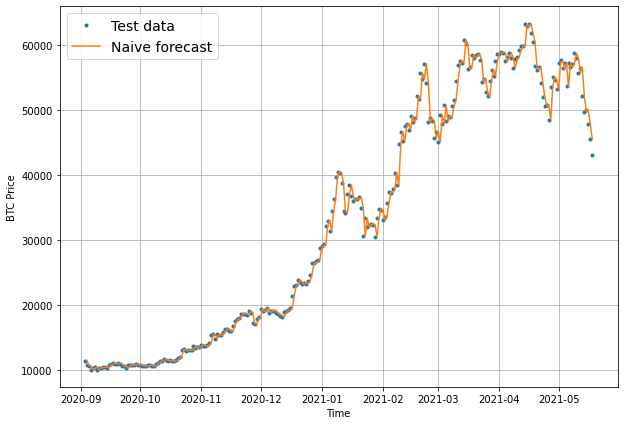

In [14]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

When we zoom in we see the naïve forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

## Evaluating a time series model

Time series forecasting often involves predicting a number (in our case, the price of Bitcoin)(**regression**).

we can use regression evaluation metrics to evaluate our time series forecasts.

> 📖 **Resource:** We're going to be using several metrics to evaluate our different model's time series forecast accuracy. Many of them are sourced and explained mathematically and conceptually in [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html).

### Scale-dependent errors

These are metrics which can be used to compare time series values and forecasts that are on the same scale.

For example, Bitcoin historical prices in USD veresus Bitcoin forecast values in USD.

| Metric | Details | Code |
| ----- | ----- | ----- |
| **MAE** (mean absolute error) | Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median. | [`tf.keras.metrics.mean_absolute_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanAbsoluteError) |
| **RMSE** (root mean square error) | Forecasts which minimise the RMSE lead to forecasts of the mean. | `tf.sqrt(`[`tf.keras.metrics.mean_square_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError)`)`|

### Percentage errors

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MAPE** (mean absolute percentage error) | Most commonly used percentage error. May explode (not work) if `y=0`. | [`tf.keras.metrics.mean_absolute_percentage_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MAPE) | 
| **sMAPE** (symmetric mean absolute percentage error) | Recommended not to be used by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), though it is used in forecasting competitions. | Custom implementation |

### Scaled errors

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MASE** (mean absolute scaled error). | MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naïve should get <1 MASE. | See sktime's [`mase_loss()`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |


Since we're going to be evaluing a lot of models, let's write a function to help us calculate evaluation metrics on their forecasts.

In [15]:
import tensorflow as tf

And since TensorFlow doesn't have a ready made version of MASE (mean aboslute scaled error), how about we create our own?

We'll take inspiration from [sktime](https://github.com/alan-turing-institute/sktime)'s (Scikit-Learn for time series) [`MeanAbsoluteScaledError`](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.performance_metrics.forecasting.MeanAbsoluteScaledError.html#sktime.performance_metrics.forecasting.MeanAbsoluteScaledError) class which calculates the MASE.

In [16]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

We're comparing the MAE of our predictions on the test to the MAE of the naïve forecast on the test set.

In practice, if we've created the function correctly, the naïve model should achieve an MASE of 1 (or very close to 1). Any model worse than the naïve forecast will achieve an MASE of >1 and any model better than the naïve forecast will achieve an MASE of <1.

Let's put each of our different evaluation metrics together into a function.

In [17]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Looking good! How about we test our function on the naive forecast?

In [18]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

Taking a look at the naïve forecast's MAE, it seems on average each forecast is ~$567 different than the actual Bitcoin price.

How does this compare to the average price of Bitcoin in the test dataset?

In [19]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737222

Okay, looking at these two values is starting to give us an idea of how our model is performing:
* The average price of Bitcoin in the test dataset is: $20,056 

* Each prediction in naive forecast is on average off by: $567


## Format Data Part 2: Windowing dataset

Windowing is a method to turn a time series dataset into **supervised learning problem**. 

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (`window=7`) to predict the next single value (`horizon=1`) might look like:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

Or for the price of Bitcoin, it'd look like:

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

![windows and horizons for turning time series data into a supervised learning problem](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-windows-and-horizons.png)
*Example of windows and horizons for Bitcoin data. Windowing can be used to turn time series data into a supervised learning problem.*

Let's build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.

We'll start with the default horizon size of 1 and a window size of 7.

In [20]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

Now we'll write a function to take in an array and turn it into a window and horizon.

In [21]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [22]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(1,9), axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


Now we need a way to make windows for an entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage [NumPy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

Let's write a function which:
1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses NumPy indexing to create a 2D of multiple window steps, for example: 
```
[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Uses the 2D array of multuple window steps to index on a target series
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

> 📖 **Resource:** The function created below has been adapted from Syafiq Kamarul Azman's article [*Fast and Robust Sliding Window Vectorization with NumPy*](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5).

In [23]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  ex of window_indexes :
      [[0 1 2 3 4 5 6 7]] +  [[0],    = [[ 0,  1,  2,  3,  4,  5,  6,  7],
                              [1],       [ 1,  2,  3,  4,  5,  6,  7,  8],
                              [2],       [ 2,  3,  4,  5,  6,  7,  8,  9],
                              [3]]       [ 3,  4,  5,  6,  7,  8,  9, 10],]    
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [24]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [25]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [26]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


#### ANOTHER METHOD USING `tf.keras.utils.timeseries_dataset_from_array`

In [27]:
# split = int(0.8 * len(prices))

# features_prices_train = prices[:split+WINDOW_SIZE-1]
# features_prices_test = prices[split:-1]

# labels_prices_train = prices[WINDOW_SIZE:split+WINDOW_SIZE]
# labels_prices_test = prices[split+WINDOW_SIZE:]

# train_windows_ds = tf.keras.utils.timeseries_dataset_from_array(features_prices_train, labels_prices_train,
#                                              sequence_length=WINDOW_SIZE).prefetch(tf.data.AUTOTUNE)
# test_windows_ds = tf.keras.utils.timeseries_dataset_from_array(features_prices_test, labels_prices_test,
#                                              sequence_length=WINDOW_SIZE).prefetch(tf.data.AUTOTUNE)

In [28]:
# # View the first 3 windows
# np.array(train_windows_ds.take(1).get_single_element()[0][:3])

In [29]:
# # View the first 3 labels
# labels_prices_train[:3]

## Turning windows into training and test sets 

We could've windowed our existing training and test splits, however, with the nature of windowing (windowing often requires an offset at some point in the data), it usually works better to window the data first, then split it into training and test sets.

Let's write a function which takes in full sets of windows and their labels and splits them into train and test splits.

In [30]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [31]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [32]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [33]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint


we'll implement a [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback.

The `ModelCheckpoint` callback will monitor our model's performance during training and save the best model to file by setting `save_best_only=True`.

Because we're going to be running multiple experiments, it makes sense to keep track of them by saving models to file under different names.

To do this, we'll write a small function to create a `ModelCheckpoint` callback which saves a model to specified filename.

In [34]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Model 1: Dense model (window = 7, horizon = 1)

We're going to start with `model_1` will have:
* A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
* An output layer with linear activation (or no activation)
* Adam optimizer and MAE loss function
* Batch size of 128
* 100 epochs

In [35]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
18/18 [==============================] - 12s 95ms/step - loss: 780.3455 - mae: 780.3455 - val_loss: 2279.6528 - val_mae: 2279.6528
Epoch 2/100
18/18 [==============================] - 2s 100ms/step - loss: 247.6756 - mae: 247.6756 - val_loss: 1005.9992 - val_mae: 1005.9992
Epoch 3/100
18/18 [==============================] - 2s 99ms/step - loss: 188.4116 - mae: 188.4116 - val_loss: 923.2863 - val_mae: 923.2863
Epoch 4/100
18/18 [==============================] - 3s 150ms/step - loss: 169.4340 - mae: 169.4340 - val_loss: 900.5872 - val_mae: 900.5872
Epoch 5/100
18/18 [==============================] - 3s 159ms/step - loss: 165.0895 - mae: 165.0895 - val_loss: 895.2236 - val_mae: 895.2236
Epoch 6/100
18/18 [==============================] - 2s 98ms/step - loss: 158.5210 - mae: 158.5210 - val_loss: 855.1985 - val_mae: 855.1985
Epoch 7/100
18/18 [==============================] - 2s 98ms/step - loss: 151.3566 - mae: 151.3566 - val_loss: 840.9167 - val_mae: 840.9166
Epoch 8/100


In [36]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 568.9510 - mae: 568.9510


[568.9510498046875, 568.9510498046875]

## Making forecasts with a model (on the test dataset)

Since we're going to be running more modelling experiments, let's write a function which: 
1. Takes in a trained model
2. Takes in some input data
3. Passes the input data to the model's `predict()` method
4. Returns the predictions



In [37]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [38]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8861.713, 8769.888, 9015.712, 8795.52 , 8723.812, 8730.111,
        8691.953, 8502.056, 8460.962, 8516.548], dtype=float32)>)

Now we've got some prediction values, we'll use the `evaluate_preds()` we created before to compare them to the ground truth.

In [39]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 568.95105,
 'mse': 1171743.9,
 'rmse': 1082.4712,
 'mape': 2.5448983,
 'mase': 0.9994894}

How did our model go? Did it beat the naïve forecast?

In [40]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

It looks like our naïve model beats our first deep model on nearly every metric.

That goes to show the power of the naïve model and the reason for having a baseline for any machine learning project.


Let's use the `plot_time_series()` function to plot `model_1_preds` against the test data.

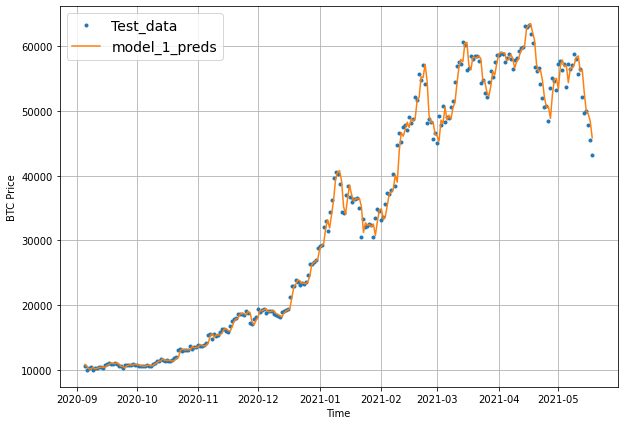

In [41]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.squeeze(test_labels), start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)

We'll keep the previous model architecture but use a window size of 30.

In other words, we'll use the previous 30 days of Bitcoin prices to try and predict the next day price.

In [42]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [43]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [44]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [45]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: mod

In [46]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 608.9620


608.9619750976562

In [47]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

In [48]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 608.962,
 'mse': 1281440.6,
 'rmse': 1132.0073,
 'mape': 2.7693412,
 'mase': 1.0644715}

It looks like `model_2` performs worse than the naïve model as well as `model_1`!

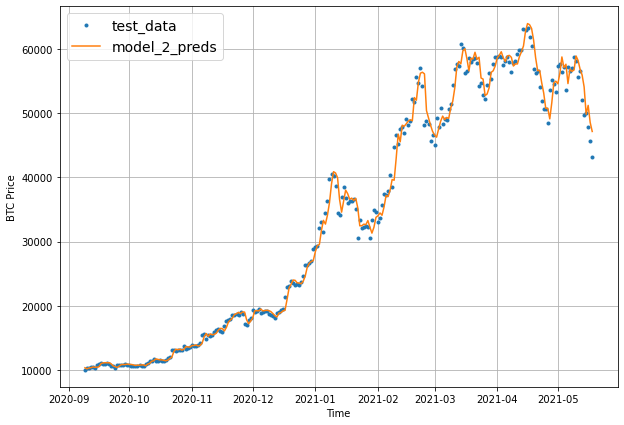

In [49]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds") 

## Model 3: Dense (window = 30, horizon = 7)

Let's try and predict 7 days ahead given the previous 30 days.

In [50]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [51]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [52]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: mod

In [53]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 1234.8838


1234.8837890625

In this case, the error will be higher because we're predicting 7 steps at a time. 

In [54]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9250.798, 9279.124, 9394.039, 9400.203, 9479.183, 9375.264,
        9302.472],
       [8945.557, 9029.439, 9164.761, 8997.948, 9077.654, 8971.883,
        9081.854],
       [8883.711, 8987.258, 9057.07 , 8901.714, 9001.872, 8817.509,
        8971.558],
       [9090.947, 9014.501, 9010.567, 9096.448, 9052.973, 9016.151,
        9001.476],
       [9002.045, 8972.497, 8869.771, 8980.389, 9212.569, 9072.293,
        8887.335]], dtype=float32)>

In [55]:
# Calculate model_3 results - these are going to be multi-dimensional because
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  561.2253  ,   301.9714  ,   297.9477  ,   413.84305 ,
          445.20926 ,   540.59717 ,   527.2284  ,   441.84564 ,
          498.7735  ,   639.19226 ,   803.132   ,   731.72614 ,
          678.6171  ,   797.1857  ,   575.334   ,   280.21143 ,
          239.92166 ,   246.15207 ,   276.387   ,   285.75482 ,
          118.8042  ,   135.45557 ,   191.11844 ,   251.82582 ,
          170.28934 ,   154.20027 ,   107.244835,    97.662735,
          111.26402 ,   139.854   ,   269.1739  ,   369.81207 ,
          270.48102 ,   263.1211  ,   247.72252 ,   255.50502 ,
          298.48172 ,   245.26402 ,   243.13094 ,   255.7583  ,
          416.62576 ,   150.97021 ,    94.16581 ,   101.62012 ,
           93.76974 ,    86.75321 ,    73.2793  ,    79.045204,
           89.541084,    93.11977 ,   106.79862 ,   141.0957  ,
          178.73674 ,   145.46994 ,   256.4566  ,   392.81647 ,
          560.9116  ,   552.8188  ,   536.1548  ,   535.26874 ,
          448.70453 ,   267.2329 

## Make evaluation function work for larger horizons

The outputs for `model_3_results` are multi-dimensional. 

This is because the predictions are getting evaluated across the `HORIZON` timesteps (7 predictions at a time).

To fix this, let's adjust our `evaluate_preds()` function to work with multiple shapes of data.

In [56]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [57]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1234.8838,
 'mse': 5393734.0,
 'rmse': 1419.1364,
 'mape': 5.4874988,
 'mase': 2.1974065}

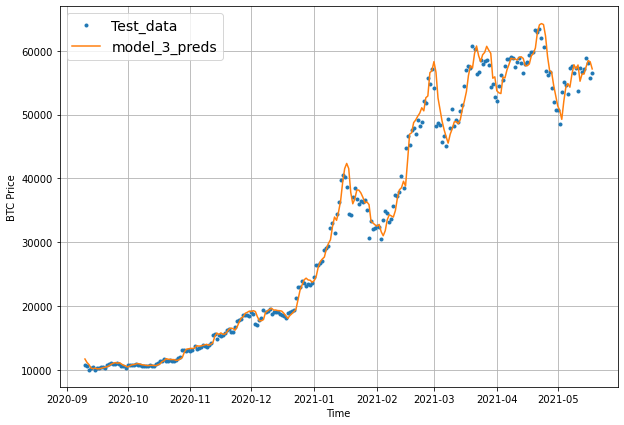

In [58]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 format="-",
                 start=offset, 
                 label="model_3_preds")

## Which of our models is performing best so far?

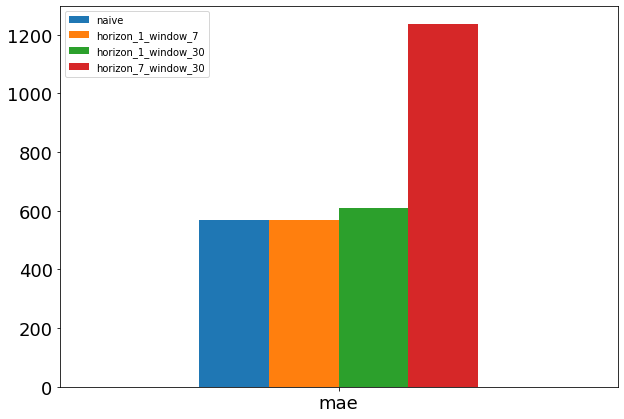

In [59]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar", rot=0,fontsize=18);

Naïve model is performing best (it's very hard to beat a naïve model in open systems) but the dense model with a horizon of 1 and a window size of 7 looks to be performing cloest.

Because of this, let's use `HORIZON=1` and `WINDOW_SIZE=7` for our next series of modelling experiments (in other words, we'll use the previous week of Bitcoin prices to try and predict the next day).

## Model 4: Conv1D

Onto the next modelling experiment!

This time, we'll be using a Conv1D model. Conv1D models can be used for seq2seq (sequence to sequence) problems.

In our case, the input sequence is the previous 7 days of Bitcoin price data and the output is the next day (in seq2seq terms this is called a many to one problem).

![bitcoin prediction in seq2seq terms](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-bitcoin-forecast-in-seq2seq-terms.png)
*Framing Bitcoin forecasting in seq2seq (sequence to sequence) terms. Using a window size of 7 and a horizon of one results in a many to one problem. Using a window size of >1 and a horizon of >1 results in a many to many problem. The diagram comes from Andrei Karpathy's [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*.

In [60]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [61]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [62]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

Since we're going to be using [Conv1D layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), we need to make sure our input shapes are correct.

The Conv1D layer in TensorFlow takes an input of: `(batch_size, timesteps, input_dim)`.

In our case, the `batch_size` (by default this is 32 but we can change it) is handled for us but the other values will be:
* `timesteps = WINDOW_SIZE` - the `timesteps` is also often referred to as `features`, our features are the previous `WINDOW_SIZE` values of Bitcoin 
* `input_dim = HORIZON` - our model views `WINDOW_SIZE` (one week) worth of data at a time to predict `HORIZON` (one day)

Right now, our data has the `timesteps` dimension ready but we'll have to adjust it to have the `input_dim` dimension. 

In [63]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

To fix this, we could adjust the shape of all of our `train_windows` or we could use a [`tf.keras.layers.Lamdba`](https://keras.io/api/layers/core_layers/lambda/) to do this for us in our model.

In [64]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [65]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  expand_dims_layer, # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets wr

What does the Lambda layer look like in a summary?

In [66]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 1s 12ms/step - loss: 570.8285


570.8284912109375

In [68]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8851.464, 8754.47 , 8983.927, 8759.671, 8703.627, 8708.294,
       8661.667, 8494.839, 8435.316, 8492.114], dtype=float32)>

In [69]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 570.8284,
 'mse': 1176671.4,
 'rmse': 1084.7449,
 'mape': 2.5593355,
 'mase': 1.0027875}

## Model 5: RNN (LSTM)

The [`tf.keras.layers.LSTM()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layer takes a tensor with `[batch, timesteps, feature]` dimensions.

In [70]:
tf.random.set_seed(42)

# building an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = expand_dims_layer(inputs) # expand input dimension to be compatible with LSTM
x = layers.LSTM(128, activation="relu", return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


In [71]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 1s 6ms/step - loss: 587.4613


587.4613037109375

In [72]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8919.437, 8765.388, 9028.273, 8818.101, 8695.348, 8790.766,
       8709.219, 8500.637, 8493.75 , 8526.768], dtype=float32)>

In [73]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 587.4613,
 'mse': 1225966.9,
 'rmse': 1107.2339,
 'mape': 2.6290104,
 'mase': 1.0320067}

## Make a multivariate time series 

If predicting the price of Bitcoin using the price of Bitcoin hasn't worked out very well, maybe giving our model more information may help.

we could try to see if the [Bitcoin block reward size](https://www.investopedia.com/terms/b/block-reward.asp) adds any predictive power to our model(s).

The `Bitcoin block reward size` is the number of Bitcoin someone receives from mining a Bitcoin block.

For example, the block reward size went from 50 (starting January 2009) to 25 on November 28 2012.

In [74]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Alright, time to add another feature column, the block reward size.

First, we'll need to create variables for the different block reward sizes as well as the dates they came into play.

The following block rewards and dates were sourced from [cmcmarkets.com](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving).

| Block Reward | Start Date |
| ----- | ----- |
| 50 | 3 January 2009 (2009-01-03) |
| 25 | 28 November 2012 |
| 12.5 | 9 July 2016 |
| 6.25 | 11 May 2020 |
| 3.125 | TBA (expected 2024) |
| 1.5625 | TBA (expected 2028) | 

In [75]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

We're going to get the days (indexes) for different block reward values. 

This is important because if we're going to use multiple variables for our time series, they have to the same frequency as our original variable. For example, if our Bitcoin prices are daily, we need the block reward values to be daily as well.

> 🔑 **Note:** For using multiple variables, make sure they're the same frequency as each other. If your variables aren't at the same frequency (e.g. Bitcoin prices are daily but block rewards are weekly), you may need to transform them in a way that they can be used with your model.

In [76]:
block_reward_3_datetime - bitcoin_prices.index[0]

Timedelta('1012 days 00:00:00')

In [77]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

Now we can add another feature to our dataset `block_reward` (this gets lower over time so it may lead to increasing prices of Bitcoin).

In [78]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


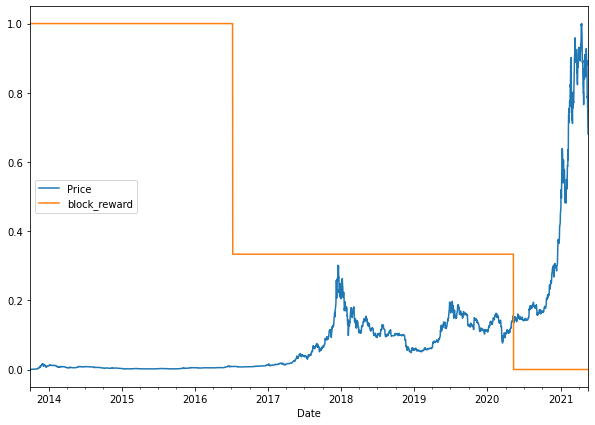

In [79]:
# Ploting the block reward/price over time
# Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

we can see the price goes up as the block reward goes down, perhaps this information will be helpful to our model's performance.

## Making a windowed dataset with pandas

since we've just added another variable to our dataset, we can leverage the [`pandas.DataFrame.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) method to create a windowed **multivariate** time series.

In [80]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [81]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [82]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [83]:
# View labels
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [84]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)

By replicating the `model_1` architecture we'll be able to see whether or not adding the block reward feature improves or detracts from model performance.

In [85]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


In [86]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 568.4490


568.448974609375

In [87]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8813.428, 8767.834, 9045.073, 8723.28 , 8713.942, 8744.135,
       8651.524, 8490.181, 8448.834, 8518.018], dtype=float32)>

In [88]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 568.449,
 'mse': 1162441.5,
 'rmse': 1078.1659,
 'mape': 2.5558863,
 'mase': 0.9986074}

In [89]:
model_1_results

{'mae': 568.95105,
 'mse': 1171743.9,
 'rmse': 1082.4712,
 'mape': 2.5448983,
 'mase': 0.9994894}

It looks like the adding in the block reward may have helped our model slightly.

## Model 7: N-BEATS algorithm

One of the best ways to improve a model's performance is to increase the number of layers in it.

That's exactly what the [N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) algorithm](https://arxiv.org/pdf/1905.10437.pdf) does.

The N-BEATS algorithm focuses on univariate time series problems and achieved state-of-the-art performance in the winner of the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128).

For next modelling experiment we're going to be replicating the **generic architecture** of the N-BEATS algorithm.

We're going to focus on:
1. Replicating the model architecture in [Figure 1 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf) 

![figure 1 from N-BBEATS paper, the algorithm we're going to build](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-figure-1-nbeats-paper-annotated.png)
*N-BEATS algorithm we're going to replicate with TensorFlow with window (input) and horizon (output) annotations.*

2. Using the same hyperparameters as the paper which can be found in [Appendix D of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)

### Building and testing an N-BEATS block layer

In [90]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs 
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [91]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [92]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]])>

In [93]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.4634871   0.10944445 -0.4335533   0.9360242  -0.35703525 -0.17927599
 -0.3404836 ]
Forecast: -0.43979012966156006


### Preparing data for the N-BEATS algorithm using `tf.data`

Because we're going to be using a larger model architecture, to ensure our model training runs as fast as possible, we'll setup our datasets using the `tf.data` API.

In [94]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [95]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [96]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [97]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [98]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

### Setting up hyperparameters for N-BEATS algorithm

we'll create variables for each of the hyperparameters we'll be using for our N-BEATS replica.

> 📖 **Resource:** The following hyperparameters are taken from Figure 1 and Table 18/Appendix D of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf).

![table 18 from N-BEATS paper](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-table-18-hyperparameters.png)

*Table 18 from [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf) describing the hyperparameters used for the different variants of N-BEATS. We're using N-BEATS-G which stands for the generic version of N-BEATS.*

In [99]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # "Iterations" in Table 18
N_NEURONS = 512 # "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

There are two layers to go through which play a large roll in the architecture.

* [`tf.keras.layers.subtract(inputs)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/subtract)
* [`tf.keras.layers.add(inputs)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/add)

In the case of N-BEATS, the architecture uses residual connections which:
* Subtract the backcast outputs from a previous block from the backcast inputs to the current block
* Add the forecast outputs from all blocks together in a stack 

![N-BEATS architecture double residual stacking](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-architecture-double-residual-stacking.png)
*Annotated version of Figure 1 from the N-BEATS paper highlighting the double residual stacking (section 3.2) of the architecture. Backcast residuals of each block are subtracted from each other and used as the input to the next block where as the forecasts of each block are added together to become the stack forecast.*


### Building, compiling and fitting the N-BEATS algorithm 

In [100]:
tf.random.set_seed(42)

# Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted above

  # Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals)

  # Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i+1}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i+1}")

# Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, 
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 00277: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00377: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [101]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 85ms/step - loss: 579.1954 - mae: 579.1954 - mse: 1234859.7500


[579.1954345703125, 579.1954345703125, 1234859.75]

In [102]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8937.432, 8840.672, 9067.272, 8815.201, 8776.18 , 8815.498,
       8699.271, 8561.56 , 8534.22 , 8564.647], dtype=float32)>

In [103]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 579.19543,
 'mse': 1234859.8,
 'rmse': 1111.2424,
 'mape': 2.6190634,
 'mase': 1.017486}

It looks like the N-BEATS model doesn't perform as well as `model_1` or the original naive forecast.

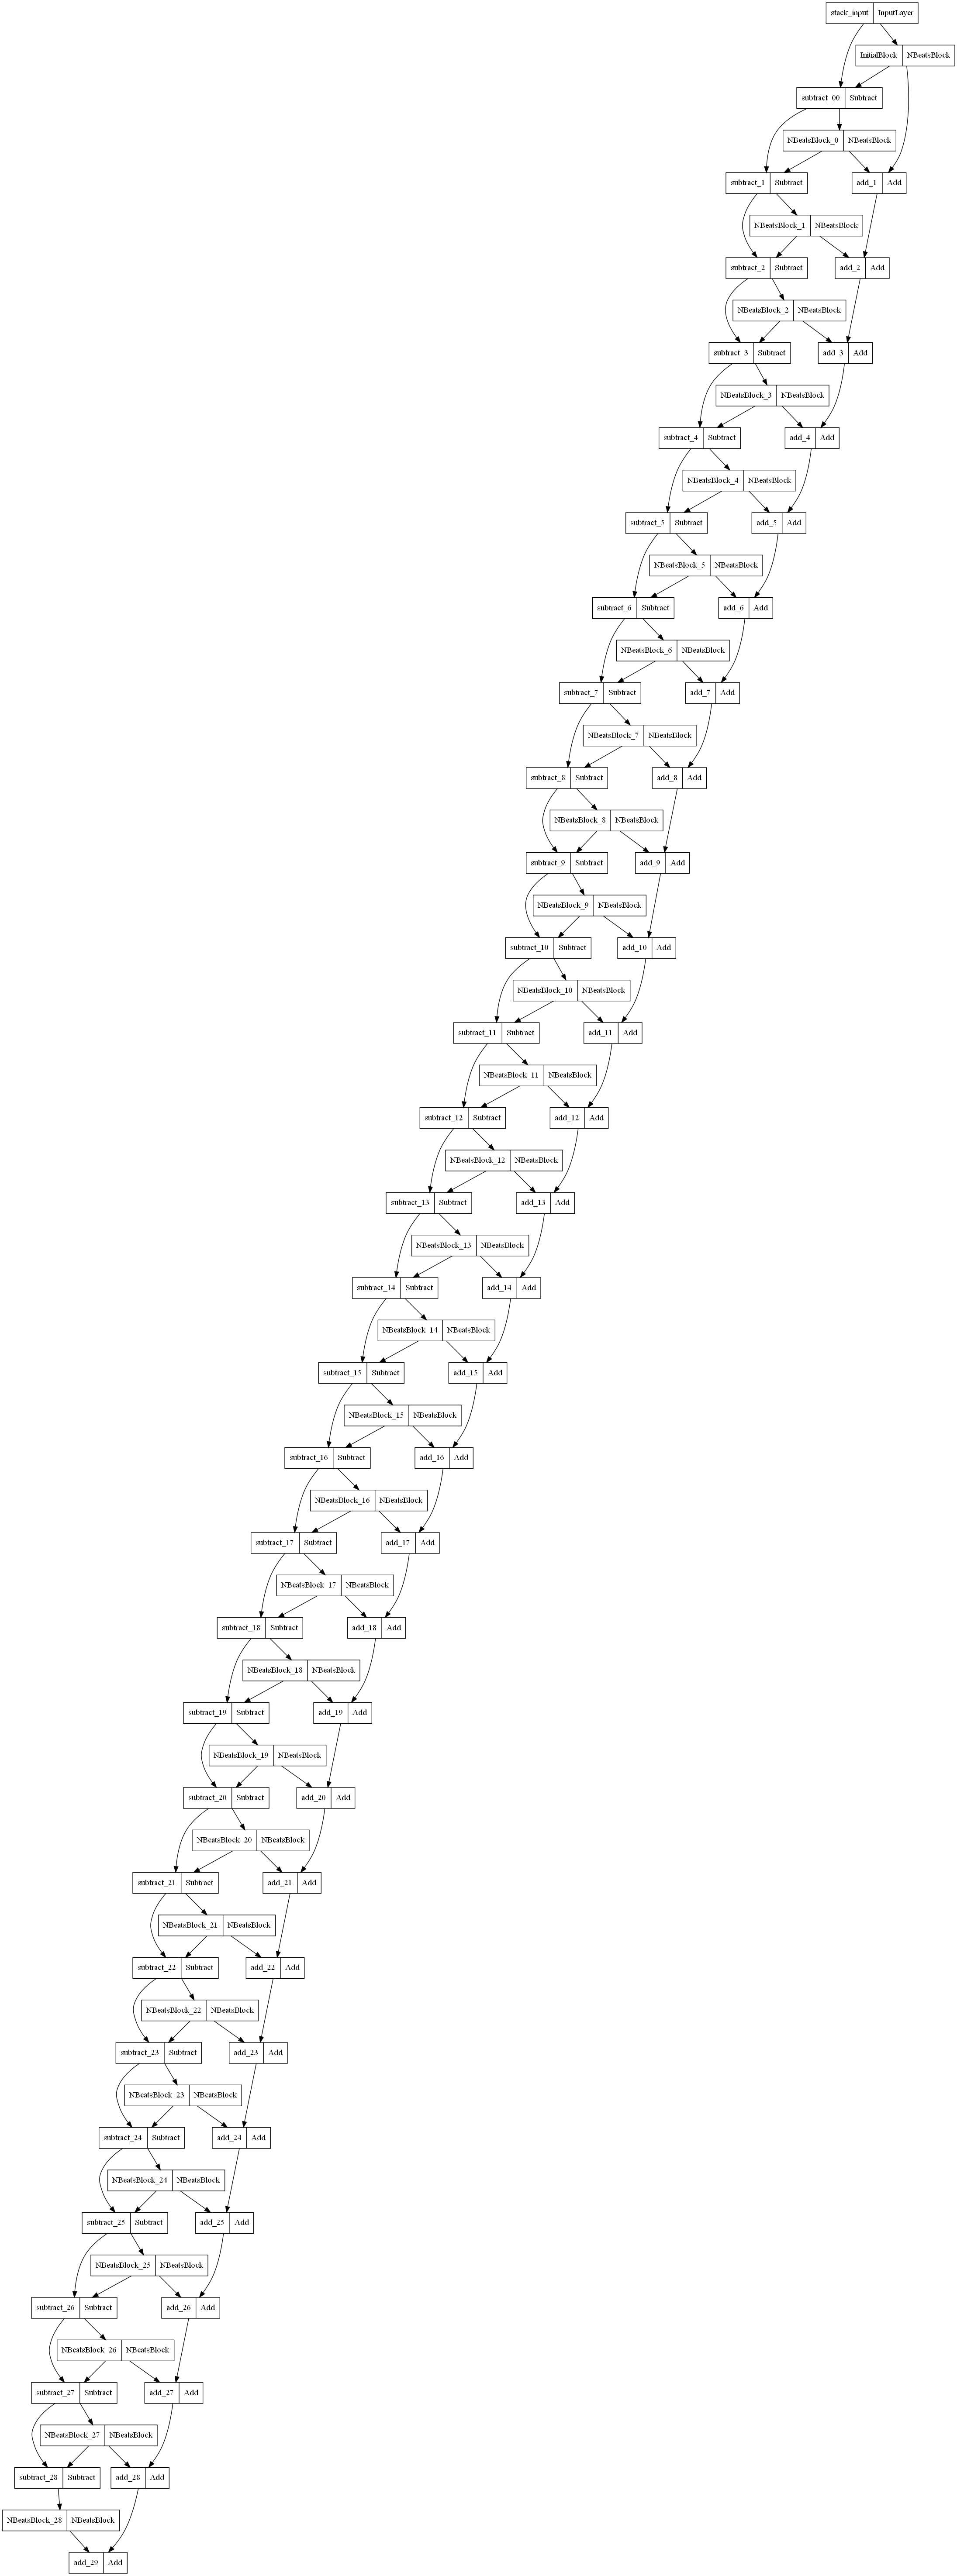

In [104]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

In [105]:
# This will error out unless a "get_config()" method is implemented - this could be extra curriculum
model_7.save(f"./model_experiments/{model_7.name}")

INFO:tensorflow:Assets written to: ./model_experiments/model_7_N-BEATS\assets


INFO:tensorflow:Assets written to: ./model_experiments/model_7_N-BEATS\assets
D:\Conda\tensorflow-gpu\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
D:\Conda\tensorflow-gpu\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## Model 8: Creating an ensemble (stacking different models together)

Next experiment is creating an [**ensemble** of models](https://en.wikipedia.org/wiki/Ensemble_learning).

An **ensemble** involves training and combining multiple different models on the same problem.

To create our ensemble models we're going to be using a combination of: 
* Different loss functions (MAE, MSE, MAPE)
* Randomly initialized models 

Let's find out!

We'll start by creating a function to produce a list of different models trained with different loss functions. Each layer in the ensemble models will be initialized with a random normal [(Gaussian) distribution](https://en.wikipedia.org/wiki/Normal_distribution) using [He normal initialization](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal), this'll help estimating the prediction intervals.

### Constructing and fitting an ensemble of models (using different loss functions)

In [106]:
def get_ensemble_models(horizon=HORIZON, 
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10, 
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models


by running `num_iter=5` runs for 1000 epochs. This will result in 15 total models (5 for each different loss function).

In [107]:
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 00610: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00726: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00826: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 00168: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00268: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 00424: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00524: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 1

Epoch 00177: ReduceLR

### Making predictions with an ensemble model

In [108]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [109]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8782.386,  8781.982,  9069.22 , ..., 50562.906, 49946.   ,
        46512.117],
       [ 8770.869,  8746.121,  9054.784, ..., 49379.03 , 48531.24 ,
        45355.34 ],
       [ 8745.424,  8733.031,  9101.386, ..., 49267.17 , 47660.434,
        45370.047],
       ...,
       [ 8905.609,  8760.604,  9036.345, ..., 49554.766, 49272.105,
        46390.68 ],
       [ 8722.948,  8804.047,  9095.481, ..., 49550.582, 48483.375,
        45068.57 ],
       [ 8816.235,  8760.283,  9039.528, ..., 49719.73 , 48054.71 ,
        45821.332]], dtype=float32)>

In [110]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 567.65625,
 'mse': 1146174.6,
 'rmse': 1070.5955,
 'mape': 2.5812242,
 'mase': 0.9972148}

The ensemble model is the best performing model on the MAE metric so far.

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

**point predictions** are almost always going to be wrong. So having a range of values can help with decision making.

> 📖 **Resource(s):** 
> * The steps we're about to take have been inspired by the Machine Learning Mastery blog post [*Prediction Intervals for Deep Learning Neural Networks*](https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/). Check out the post for more options to measure uncertainty with neural networks.
> * For an example of uncertainty estimates being used in the wild, I'd also refer to Uber's [*Engineering Uncertainty Estimation in Neural Networks for Time Series Prediction at Uber*](https://eng.uber.com/neural-networks-uncertainty-estimation/) blog post.

![example of Uber's prediction intervals for daily completed trips in San Francisco](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-prediction-intervals-from-ubers-uncertainty-measures.png)
*Example of how uncertainty estimates and predictions intervals can give an understanding of where point predictions (a single number) may not include all of useful information you'd like to know. For example, your model's point prediction for Uber trips on New Years Eve might be 100 (a made up number) but really, the prediction intervals are between 55 and 153 (both made up for the example). In this case, preparing 100 rides might end up being 53 short (it could even be more, like the point prediction, the prediction intervals are also estimates). The image comes from Uber's [blog post on uncertainty estimation in neural networks](https://eng.uber.com/neural-networks-uncertainty-estimation/).*

One way of getting the 95% condfidnece prediction intervals for a deep learning model is the bootstrap method: 
1. Take the predictions from a number of randomly initialized models (`ensemble model`)
2. Measure the standard deviation of the predictions
3. Multiply standard deviation by [1.96](https://en.wikipedia.org/wiki/1.96) (assuming the distribution is Gaussian, 95% of observations fall within 1.96 standard deviations of the mean, this is why we initialized our neural networks with a normal distribution)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)


In [111]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # Take the predictions of multiple randomly initialized deep learning neural networks
  
  # Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)
  
  # Multiply the standard deviation by 1.96
  interval = 1.96 * std    # https://en.wikipedia.org/wiki/1.96 

  # Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95% 
lower, upper = get_upper_lower(preds=ensemble_preds)

We will plot them against our ensemble model's predictions.

To do so, we can use our plotting function as well as the [`matplotlib.pyplot.fill_between()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html) method to shade in the space between the upper and lower bounds.

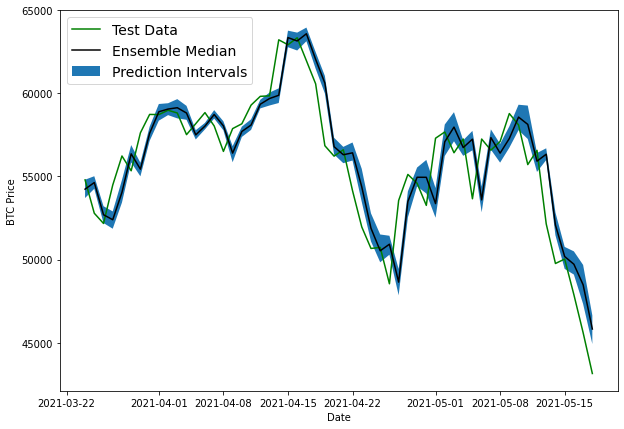

In [112]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

It looks like the ensemble predictions are lagging slightly behind the actual data.

The combination of lagging predictions as well as low prediction intervals indicates that our ensemble model may be **overfitting** the data, meaning it's basically replicating what a naïve model would do and just predicting the previous timestep value for the next value.

## Model 9: Train a model on the full historical data to make predictions into future

We will created a model which is able to make `future` predictions on the price of Bitcoin.

To make predictions into the future, we'll train a model on the **full** dataset and then get to make predictions to some future horizon.

In [113]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [114]:
# Train model on entire data to make prediction for the next day 
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [115]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>

And now let's create a model similar to `model_1` except with an extra layer, we'll also fit it to the entire dataset for 100 epochs.

In [116]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0) # don't print out anything, we've seen this all before

In [117]:
# Make predictions with our LSTM model
model_9_preds = make_preds(model_9, test_windows)
model_9_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9372.954, 9412.352, 9455.202, 9349.505, 9307.749, 9144.701,
       8881.914, 8946.49 , 9029.84 , 8804.284], dtype=float32)>

### Make predictions on the future

In [118]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14   # 14 days

![flowchart representation prediction loop to make forecasts and then append forecasts to data and make more forecasts continuously until forecast horizon is exhausted](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-prediction-loop-for-forecasts.png)

*Example flow chart representing the loop we're about to create for making forecasts. Not pictured: retraining a forecasting model every time a forecast is made & new data is acquired. For example, if you're predicting the price of Bitcoin daily, you'd want to retrain your model every day, since each day you're going to have a new data point to work with.*

1. Function which takes as input: 
  * a list of values (the Bitcoin historical data)
  * a trained model (such as `model_9`)
  * a window into the future to predict (our `INTO_FUTURE` variable)
  * the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the function) and extracts the last `WINDOW_SIZE` values from the input values (predictions will start from the last `WINDOW_SIZE` values of the training data)
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` datasets which update to remove the first the value and append the latest prediction 
  * Eventually future predictions will be made using the model's own previous predictions as input

In [119]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
  for _ in range(into_future):
    
    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

Nice! Time to bring BitPredict 💰📈 to life and make future forecasts of the price of Bitcoin.

> 🛠 **Exercise:** In terms of a forecasting model, what might another approach to our `make_future_forecasts()` function? Recall, that for making forecasts, you need to retrain a model each time you want to generate a new prediction. 
>
> So perhaps you could try to: make a prediction (one timestep into the future), retrain a model with this new prediction appended to the data, make a prediction, append the prediction, retrain a model... etc. 
>
> As it is, the `make_future_forecasts()` function skips the retraining of a model part.

In [120]:
# Make forecasts into future of the price of Bitcoin
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55764.46484375

Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55764.46484375] -> Prediction: 50985.9453125

Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55764.46484375 50985.9453125 ] -> Prediction: 48522.96875

Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55764.46484375 50985.9453125  48522.96875   ] -> Prediction: 48137.203125

Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55764.46484375
 50985.9453125  48522.96875    48137.203125  ] -> Prediction: 47880.6328125

Predicting on: 
 [45604.61575361 43144.47129086 55764.46484375 50985.9453125
 48522.96875    48137.203125   47880.6328125 ] -> Prediction: 46879.71484375

Predicting on: 
 [43144.47129086 55764.46484375 50985.9453125  48522.968

In [121]:
future_forecast[:10]

[55764.465,
 50985.945,
 48522.97,
 48137.203,
 47880.633,
 46879.715,
 48227.598,
 53963.69,
 49685.56,
 47596.176]

### Plot future forecasts

To do so, we'll use a combination of NumPy's [`datetime64` datatype](https://numpy.org/doc/stable/reference/arrays.datetime.html) (our Bitcoin dates are already in this datatype) as well as NumPy's `timedelta64` method which helps to create date ranges.

In [122]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

The start date of our forecasted dates will be the last date of our dataset. 

In [123]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [124]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

Look at that! We've now got a list of dates we can use to visualize our future Bitcoin predictions.

But to make sure the lines of the plot connect (try not running the cell below and then plotting the data to see what I mean), let's insert the last timestep and Bitcoin price of our training data to the `next_time_steps` and `future_forecast` arrays.

In [125]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, prices[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55764.465, 50985.945, 48522.97 , 48137.203, 47880.633,
        46879.715, 48227.598, 53963.69 , 49685.56 , 47596.176, 48114.426,
        48808.004, 48623.848, 50178.723], dtype=float32))

Time to plot!

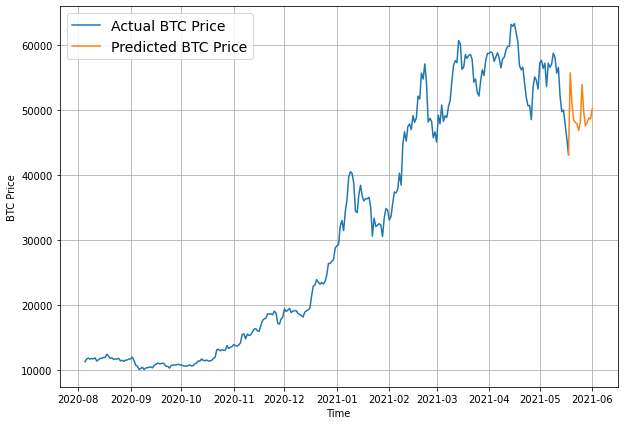

In [126]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, prices, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

It looks like our predictions are starting to form a bit of a cyclic pattern (up and down in the same way).

Perhaps that's due to our model overfitting the training data and not generalizing well for future data.

## Compare Models

In [127]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,567.980225,1147547.000,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,568.951050,1171743.875,1082.471191,2.544898,0.999489
model_2_dense_w30_h1,608.961975,1281440.625,1132.007324,2.769341,1.064471
model_3_dense_w30_h7,1234.883789,5393734.000,1419.136353,5.487499,2.197407
model_4_CONV1D,570.828430,1176671.375,1084.744873,2.559335,1.002787
model_5_LSTM,587.461304,1225966.875,1107.233887,2.629010,1.032007
model_6_multivariate,568.448975,1162441.500,1078.165894,2.555886,0.998607
model_8_NBEATs,579.195435,1234859.750,1111.242432,2.619063,1.017486
model_9_ensemble,567.656250,1146174.625,1070.595459,2.581224,0.997215


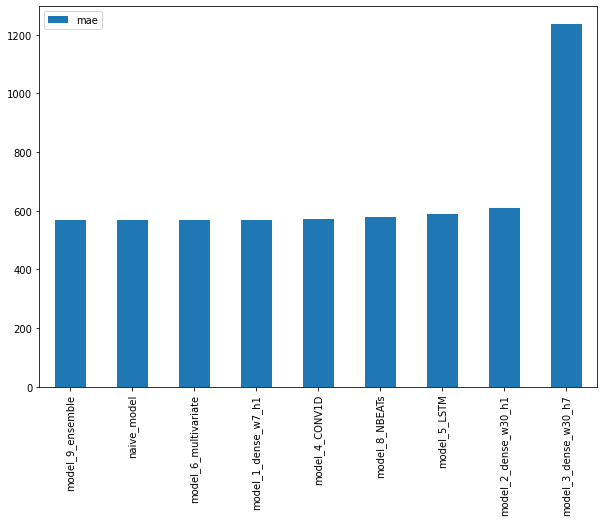

In [128]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");

The majority of our deep learning models perform on par or only slightly better than the naive model.